# TranscriptHomies 🧬🤝

Explore how genes work together. This tool maps gene–gene expression correlations within your dataset, helping you discover coordinated expression patterns and visualize network structures that define biological systems.

Team Members: Grace Beggs, Caroline Harrer, HeaJin Hong, Tess Kelly, Zilin Xianyu¶

TAs: Riley Kellermeyer, Bekah Kim

## Input for Scatter Plot

In [1]:
#!/usr/bin/env python3

import pandas as pd

def make_dictionary_from_raw_data_for_visualisation(filename):

    # Read the file
    df = pd.read_csv(filename, sep="\t", engine="python")

    # Clean column names
    df.columns = df.columns.str.strip()

    # Extract gene identifier column
    gene_identifier = df['symbol']

    # Extract experimental and control columns
    df_experimental = df.iloc[:, 1:7]  # columns 1 to 6
    df_control = df.iloc[:, 7:12]      # columns 7 to 11

    # Combine gene identifier with experimental/control data
    df_ds_experimental = pd.concat([gene_identifier, df_experimental], axis=1)
    df_ds_control = pd.concat([gene_identifier, df_control], axis=1)

    # Create dictionaries
    gene_dict_experimental = df_ds_experimental.set_index('symbol').apply(list, axis=1).to_dict()
    gene_dict_control = df_ds_control.set_index('symbol').apply(list, axis=1).to_dict()

    return gene_dict_control, gene_dict_experimental

# test run
filename = "GSE280284_Processed_data_files.txt"
dictionary_complete_tuple = make_dictionary_from_raw_data_for_visualisation(filename)
# call dictionaries from tuple that is returned by function
control_dict = dictionary_complete_tuple[0] 
experimental_dict = dictionary_complete_tuple[1]

#print(f'control_dict: {control_dict}')
#print(f'experimental: {experimental_dict}')

print(f'Control and Experimental dictionaries complete')

Control and Experimental dictionaries complete


## DATA ANALYSIS

## Section 1: Import Libraries and Set Parameters

In [2]:
# Breast Cancer DESeq2 Paired Analysis
# This notebook performs differential expression analysis comparing tumor (C) vs normal (CP) breast tissue samples using a paired design.

import pandas as pd
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

# Hardcoded parameters
file = "GSE280284_Processed_data_files.txt"
cond1 = "C"
cond2 = "CP"

## Section 2: Load Expression Data

In [3]:
print(f"📂 Reading file: {file}")
df = pd.read_csv(file, sep="\t", index_col=0)

# Save annotation columns if they exist
gene_symbols = df["symbol"] if "symbol" in df.columns else None
gene_names = df["name"] if "name" in df.columns else None

# Drop annotation columns before DESeq2
drop_cols = [c for c in ["symbol", "name"] if c in df.columns]
df = df.drop(columns=drop_cols)

# Select relevant samples (ending with cond1 or cond2)
samples = [c for c in df.columns if c.endswith(cond1) or c.endswith(cond2)]
counts = df[samples]

print(f"Loaded {len(counts)} genes across {len(samples)} samples")

📂 Reading file: GSE280284_Processed_data_files.txt
Loaded 101816 genes across 12 samples


## Section 3: Set Exclusion Criteria and Filter Low-Count Genes

In [4]:
# Section 3: Filter Low-Count Genes

# Filtering criteria: keep genes with >= 10 counts in >= 3 samples
MIN_COUNTS = 10
MIN_SAMPLES = 3

# Identify genes that pass the filter
genes_pass_filter = (counts >= MIN_COUNTS).sum(axis=1) >= MIN_SAMPLES
filtered_counts = counts[genes_pass_filter]
removed_genes = counts[~genes_pass_filter]

# Save removed genes
removed_file = f"removed_low_count_genes_{cond1}_vs_{cond2}.txt"
removed_genes.to_csv(removed_file, sep="\t")

print(f"\n🧹 Gene Filtering Summary:")
print(f"   Total genes before filtering: {len(counts)}")
print(f"   Genes passing filter (>={MIN_COUNTS} counts in >={MIN_SAMPLES} samples): {len(filtered_counts)}")
print(f"   Genes removed: {len(removed_genes)}")
print(f"   Percentage kept: {len(filtered_counts)/len(counts)*100:.1f}%")
print(f"📁 Saved list of removed genes to: {removed_file}")


🧹 Gene Filtering Summary:
   Total genes before filtering: 101816
   Genes passing filter (>=10 counts in >=3 samples): 30264
   Genes removed: 71552
   Percentage kept: 29.7%
📁 Saved list of removed genes to: removed_low_count_genes_C_vs_CP.txt


## Section 4: Extract Patient IDs and Build Metadata

In [5]:
# Helper: extract patient ID robustly
def extract_patient_id(s, cond1, cond2):
    """Strip condition suffix and normalize IDs with or without trailing zeros."""
    if s.endswith(cond2):
        base = s[: -len(cond2)]
    elif s.endswith(cond1):
        base = s[: -len(cond1)]
    else:
        base = s
    if base.endswith("0") and (base[:-1] + cond2) in df.columns:
        base = base[:-1]
    return base

# Build metadata with patient IDs
patients = [extract_patient_id(s, cond1, cond2) for s in filtered_counts.columns]
meta = pd.DataFrame({
    "sample": filtered_counts.columns,
    "patient": patients,
    "condition": [cond1 if s.endswith(cond1) else cond2 for s in filtered_counts.columns]
}, index=filtered_counts.columns)

print("Metadata created:")
print(meta.head())

Metadata created:
                  sample    patient condition
1622003800C  1622003800C  162200380         C
1621001800C  1621001800C  162100180         C
1622003500C  1622003500C  162200350         C
1621003700C  1621003700C  162100370         C
1621002900C  1621002900C  162100290         C


## Section 5: Check and Verify Tumor-Normal Pairing

In [6]:
print("\n🔍 Checking detected tumor-normal pairs:")
tumor_samples = [s for s in filtered_counts.columns if s.endswith(cond1)]
normal_samples = [s for s in filtered_counts.columns if s.endswith(cond2)]
paired_patients, missing_pairs = [], []
for t in tumor_samples:
    pid = extract_patient_id(t, cond1, cond2)
    n_candidates = [n for n in normal_samples if extract_patient_id(n, cond1, cond2) == pid]
    if n_candidates:
        print(f"  ✅ {t}  ↔  {n_candidates[0]}")
        paired_patients.append(pid)
    else:
        print(f"  ⚠️  Missing normal pair for tumor sample: {t}")
        missing_pairs.append(pid)
for n in normal_samples:
    pid = extract_patient_id(n, cond1, cond2)
    t_candidates = [t for t in tumor_samples if extract_patient_id(t, cond1, cond2) == pid]
    if not t_candidates:
        print(f"  ⚠️  Missing tumor pair for normal sample: {n}")
        missing_pairs.append(pid)
# Keep only complete pairs
if missing_pairs:
    print(f"\n⚠️ Warning: {len(missing_pairs)} unmatched samples detected. Only complete pairs will be used.")
    paired_patients = list(set(paired_patients))
    meta = meta[meta["patient"].isin(paired_patients)]
    filtered_counts = filtered_counts[meta.index]
else:
    print("\n✅ All pairs detected successfully.")


🔍 Checking detected tumor-normal pairs:
  ✅ 1622003800C  ↔  162200380CP
  ✅ 1621001800C  ↔  162100180CP
  ✅ 1622003500C  ↔  162200350CP
  ✅ 1621003700C  ↔  162100370CP
  ✅ 1621002900C  ↔  162100290CP
  ✅ 1621002200C  ↔  162100220CP

✅ All pairs detected successfully.


## Section 6: Run DESeq2 Paired Analysis

In [7]:
print("\n⚙️ Running DESeq2 paired analysis...")
dds = DeseqDataSet(
    counts=filtered_counts.T,
    metadata=meta[["patient", "condition"]],
    design_factors=["patient", "condition"]
)
dds.deseq2()

print("✅ DESeq2 model fitting complete!")


⚙️ Running DESeq2 paired analysis...
Using None as control genes, passed at DeseqDataSet initialization


/var/folders/kp/16_99tbj5615xfqvzs3pwhth0001yj/T/ipykernel_36640/1812554715.py:2: DeprecationWarning: design_factors is deprecated and will soon be removed.Please consider providing a formulaic formula using the design argumentinstead.
  dds = DeseqDataSet(
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 5.80 seconds.

Fitting dispersion trend curve...
... done in 0.69 seconds.

Fitting MAP dispersions...
... done in 6.30 seconds.

Fitting LFCs...


✅ DESeq2 model fitting complete!


... done in 4.91 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.



## Section 7: Compute Differential Expression Statistics

In [8]:
stat_res = DeseqStats(dds, contrast=["condition", cond1, cond2])
stat_res.summary()

print("✅ Statistical testing complete!")

Running Wald tests...


Log2 fold change & Wald test p-value: condition C vs CP
                               baseMean  log2FoldChange     lfcSE      stat  \
gene_id                                                                       
NONHSAG104656.1               17.465764        0.041747  0.508319  0.082127   
ENSG00000198692               11.787293        0.285574  0.468182  0.609963   
NONHSAG104654.1                6.241093       -0.962828  0.685933 -1.403676   
NONHSAG115270.1               12.872526        0.246776  0.460818  0.535516   
NONHSAG104622.1               26.507672        0.477334  0.554165  0.861358   
...                                 ...             ...       ...       ...   
NONHSAG015447.2                9.880210        0.600383  0.520017  1.154545   
ENSG00000171502               99.138194        0.854752  0.391571  2.182875   
MSTRG.1863|ENSG00000176454   557.538246       -0.192953  0.275382 -0.700672   
ENSG00000179041              731.301219        0.361283  0.327804  1.102129

... done in 1.64 seconds.



## Section 8: Combine Results with Gene Annotations

In [9]:
results = stat_res.results_df.copy()
results.index.name = "ensembl_id"

if gene_symbols is not None:
    results = results.merge(gene_symbols, left_index=True, right_index=True, how="left")
if gene_names is not None:
    results = results.merge(gene_names, left_index=True, right_index=True, how="left")

print(f"Results table created with {len(results)} genes")
print("\nFirst few results:")
print(results.head())

Results table created with 30264 genes

First few results:
                  baseMean  log2FoldChange     lfcSE      stat    pvalue  \
ensembl_id                                                                 
NONHSAG104656.1  17.465764        0.041747  0.508319  0.082127  0.934545   
ENSG00000198692  11.787293        0.285574  0.468182  0.609963  0.541886   
NONHSAG104654.1   6.241093       -0.962828  0.685933 -1.403676  0.160415   
NONHSAG115270.1  12.872526        0.246776  0.460818  0.535516  0.592293   
NONHSAG104622.1  26.507672        0.477334  0.554165  0.861358  0.389041   

                     padj  symbol  \
ensembl_id                          
NONHSAG104656.1  0.971510       -   
ENSG00000198692  0.742169  EIF1AY   
NONHSAG104654.1  0.358785       -   
NONHSAG115270.1  0.778982       -   
NONHSAG104622.1  0.619202       -   

                                                              name  
ensembl_id                                                          
NONHSAG104

## Section 9: Save All Results

In [10]:
# Save all results (tab-delimited)
out_file = f"DE_{cond1}_vs_{cond2}_paired_filtered.txt"
results.to_csv(out_file, sep="\t")
print(f"📊 All results saved to: {out_file}")

📊 All results saved to: DE_C_vs_CP_paired_filtered.txt


## Section 10: Save Significant Results

In [11]:
sig_results = results[results["padj"] < 0.05].sort_values("padj")
sig_file = f"DE_{cond1}_vs_{cond2}_paired_filtered_significant.txt"
sig_results.to_csv(sig_file, sep="\t")
print(f"✨ Significant genes (padj < 0.05) saved to: {sig_file}")
print(f"🔬 Significant genes found: {len(sig_results)}")

✨ Significant genes (padj < 0.05) saved to: DE_C_vs_CP_paired_filtered_significant.txt
🔬 Significant genes found: 5742


## Section 11: Save Top 20 Genes

In [12]:
# Top 20 genes
top20_file = f"DE_{cond1}_vs_{cond2}_paired_filtered_top20.txt"
top20 = sig_results.head(20)
top20.to_csv(top20_file, sep="\t")
print(f"🏆 Top 20 genes saved to: {top20_file}")
print("\nTop 20 most significant genes:")
print(top20[["symbol", "log2FoldChange", "padj"]].head(20))

🏆 Top 20 genes saved to: DE_C_vs_CP_paired_filtered_top20.txt

Top 20 most significant genes:
                               symbol  log2FoldChange          padj
ensembl_id                                                         
MSTRG.4817|ENSG00000123500    COL10A1        6.629274  3.135863e-37
MSTRG.3548|ENSG00000170373       CST1        9.295430  3.838815e-33
ENSG00000165186                PTCHD1       -3.826805  1.837870e-29
ENSG00000196611                  MMP1        6.796533  9.015911e-29
MSTRG.5424|ENSG00000148053      NTRK2       -2.918228  1.144604e-21
MSTRG.4144|ENSG00000157404        KIT       -3.986134  4.225926e-21
MSTRG.2182|ENSG00000261327          -        3.697944  1.043121e-20
ENSG00000182492                   BGN        2.714305  1.748338e-20
ENSG00000187474                  FPR3        2.873087  5.474441e-20
ENSG00000135074                ADAM19        2.399363  1.617818e-19
ENSG00000154096                  THY1        2.667008  1.617818e-19
ENSG00000216490       

## Section 12: Save Filtered Counts with Annotations

In [13]:
# Save filtered counts with gene annotations
filtered_counts_with_annotations = filtered_counts.copy()
if gene_symbols is not None:
    filtered_counts_with_annotations = filtered_counts_with_annotations.merge(
        gene_symbols, left_index=True, right_index=True, how="left"
    )
if gene_names is not None:
    filtered_counts_with_annotations = filtered_counts_with_annotations.merge(
        gene_names, left_index=True, right_index=True, how="left"
    )
filtered_counts_with_annotations.to_csv('final_input_filtered.csv', index=True)
print(f"📁 Filtered count matrix saved to: final_input_filtered.csv")

📁 Filtered count matrix saved to: final_input_filtered.csv


## Section 13: Final Summary

In [14]:
print(f"\n✅ DESeq2 Analysis Complete!")
print(f"🧬 Total genes analyzed: {len(results)}")
print(f"🔬 Significant genes found: {len(sig_results)}")
print(f"\n📂 Output files created:")
print(f"   • {out_file}")
print(f"   • {sig_file}")
print(f"   • {top20_file}")
print(f"   • final_input_filtered.csv")
print(f"   • {removed_file}")


✅ DESeq2 Analysis Complete!
🧬 Total genes analyzed: 30264
🔬 Significant genes found: 5742

📂 Output files created:
   • DE_C_vs_CP_paired_filtered.txt
   • DE_C_vs_CP_paired_filtered_significant.txt
   • DE_C_vs_CP_paired_filtered_top20.txt
   • final_input_filtered.csv
   • removed_low_count_genes_C_vs_CP.txt


## Correlation Analysis

## Loading Input

In [15]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
from scipy.stats import pearsonr, spearmanr
from scipy.stats import false_discovery_control


# input 1: gene expression matrix (genes x samples)
df = pd.read_csv("final_input_filtered.csv", index_col=0)
print(df.head())

                 1622003800C  1621001800C  1622003500C  1621003700C  \
gene_id                                                               
NONHSAG104656.1            8           12           15           42   
ENSG00000198692           14            5            5           14   
NONHSAG104654.1            8            3            0            4   
NONHSAG115270.1           18           14            5           13   
NONHSAG104622.1            9            9           82           12   

                 1621002900C  1621002200C  162200380CP  162100180CP  \
gene_id                                                               
NONHSAG104656.1            7           14           18            6   
ENSG00000198692           12           21           15            6   
NONHSAG104654.1            2            9            6           10   
NONHSAG115270.1           10           14            7           16   
NONHSAG104622.1           63           11           31            8   

    

## Normalize Raw Counts

In [16]:
# Split data: all but last two columns for normalization
df_main = df.iloc[:, :-2]     # everything except last 2 columns
df_extra = df.iloc[:, -2:]    # last 2 columns kept as-is

# Convert to float and normalize
df_main = df_main.astype(float)
df_z = df_main.apply(lambda x: zscore(x), axis=1, result_type='broadcast')

# Rejoin
df_final = pd.concat([df_z, df_extra], axis=1)

# Replace rowname with second-to-last column
df_final.index = df.iloc[:, -2]
# get rid of last two columns
df_final = df_final.iloc[:, :-2]
print(df_final.head())

        1622003800C  1621001800C  1622003500C  1621003700C  1621002900C  \
symbol                                                                    
-         -0.876549    -0.504209    -0.224955     2.288335    -0.969633   
EIF1AY     0.500639    -1.430397    -1.430397     0.500639     0.071520   
-          0.475744    -1.026605    -1.928015    -0.726135    -1.327075   
-          0.979816     0.221249    -1.485528     0.031607    -0.537319   
-         -0.720726    -0.720726     2.516997    -0.587669     1.674302   

        1621002200C  162200380CP  162100180CP  162200350CP  162100370CP  \
symbol                                                                    
-         -0.318040     0.054299    -1.062718     1.822911     0.054299   
EIF1AY     2.002556     0.715199    -1.215838     0.286079    -0.357599   
-          0.776214    -0.125196     1.076684    -0.125196     0.776214   
-          0.221249    -1.106244     0.600533    -1.485528     2.117667   
-         -0.632021     

## Loading pathway of interest

In [17]:
# input 2: pathway
pathway = pd.read_csv("lin/GO_pathways_genes.csv")

poi = "GOBP_CYTOKINESIS"
genes_in_pathway = pathway.loc[pathway['Pathway'] == poi, 'Gene'].tolist()
print(f"Genes in pathway {poi}: {genes_in_pathway}")

# filter df_final to include only genes in the pathway
df_poi = df_final.loc[df_final.index.isin(genes_in_pathway)]
print("Filtered expression DataFrame:\n", df_poi.head(), "\n")

Genes in pathway GOBP_CYTOKINESIS: ['ACTR2', 'ACTR3', 'AHCTF1', 'ALKBH4', 'ANK3', 'ANKRD53', 'ANLN', 'ANXA11', 'APC', 'ARF1', 'ARF6', 'ARL3', 'ATXN10', 'AURKA', 'AURKB', 'AURKC', 'BBS4', 'BCL2L1', 'BECN1', 'BIN3', 'BIRC5', 'BIRC6', 'BRCA2', 'CALM1', 'CALM2', 'CALM3', 'CCDC66', 'CCP110', 'CDC14A', 'CDC14B', 'CDC14C', 'CDC25B', 'CDC42', 'CDC6', 'CDCA8', 'CECR2', 'CENPA', 'CENPV', 'CEP55', 'CETN2', 'CFL1', 'CHMP1A', 'CHMP1B', 'CHMP2A', 'CHMP2B', 'CHMP3', 'CHMP4A', 'CHMP4B', 'CHMP4BP1', 'CHMP4C', 'CHMP5', 'CHMP6', 'CHMP7', 'CIT', 'CKAP2', 'CNTROB', 'CSPP1', 'CUL3', 'CUL7', 'CXCR5', 'DCDC1', 'DCTN3', 'DRD2', 'DRD3', 'E2F7', 'E2F8', 'ECT2', 'EFHC1', 'ENTR1', 'ESPL1', 'EXOC1', 'EXOC2', 'EXOC3', 'EXOC4', 'EXOC5', 'EXOC6', 'EXOC6B', 'EXOC7', 'EXOC8', 'FMN2', 'FSD1', 'GIPC1', 'GIT1', 'INCENP', 'IQGAP1', 'IQGAP2', 'IQGAP3', 'IST1', 'JTB', 'KIF13A', 'KIF14', 'KIF20A', 'KIF20B', 'KIF23', 'KIF3B', 'KIF4A', 'KIF4B', 'KLHDC8B', 'KLHL13', 'KLHL21', 'KLHL9', 'LUZP1', 'LZTS2', 'MAP10', 'MAP9', 'MITD1', '

## Splitting Columns into "Disease" and "Normal" subgroups

In [18]:
# Split columns by substring
nm_cols = [c for c in df_poi.columns if "0CP" in c]
ds_cols = [c for c in df_poi.columns if "P" not in c]

# Create two separate DataFrames
df_nm = df_poi[nm_cols]
df_ds = df_poi[ds_cols]

print("NM subset:\n", df_nm.head(), "\n")
print("DS subset:\n", df_ds.head(), "\n")

NM subset:
          162200380CP  162100180CP  162200350CP  162100370CP  162100290CP  \
symbol                                                                     
CETN2      -0.333385     0.206491    -1.368841     0.115128    -0.732063   
SEPTIN6    -0.774774    -0.097936    -0.791695    -0.410205    -0.797848   
KLHL13      2.237504     1.482906    -0.269830     0.926422    -0.141119   
KIF4A      -1.126768    -0.557018    -1.034462    -0.907144    -1.120402   
ATXN10     -0.139306     2.057496    -0.789886     1.208532    -0.188902   

         162100220CP  
symbol                
CETN2      -0.164501  
SEPTIN6    -0.699399  
KLHL13      0.292964  
KIF4A      -0.716166  
ATXN10      0.814684   

DS subset:
          1622003800C  1621001800C  1622003500C  1621003700C  1621002900C  \
symbol                                                                     
CETN2       2.288476    -0.560410     0.635624     1.430211    -0.408137   
SEPTIN6     1.995646     0.661968     0.095885    -0

## Processing "Disease" Subgroup

In [19]:
expression_df = df_ds # using only NM samples for correlation
name = "DS"
expression_df = expression_df.loc[expression_df.var(axis=1) > 1e-6] 
print(expression_df)

         1622003800C  1621001800C  1622003500C  1621003700C  1621002900C  \
symbol                                                                     
CETN2       2.288476    -0.560410     0.635624     1.430211    -0.408137   
SEPTIN6     1.995646     0.661968     0.095885    -0.760930     2.057177   
KLHL13     -0.658485    -0.406111    -0.854075    -0.556274    -1.101401   
KIF4A       1.008998     0.464712     1.970252     0.773459     0.989901   
ATXN10     -0.083875    -0.113049     0.797179    -1.285844    -0.962012   
...              ...          ...          ...          ...          ...   
BECN1      -1.636028    -0.412575    -0.954973     0.545796    -1.831781   
ACTR2       1.391849     1.023247     0.203196     1.341849     1.289815   
SEPTIN9    -0.642075     0.331555    -0.168986     2.938003    -0.609633   
BIRC5       0.338088    -0.099608    -0.058114     0.667364     3.008437   
CHMP6      -1.145599     0.499249    -0.182761     0.218422    -1.814236   

         16

## Generating Correlation Matrix

In [20]:
# gene-gene correlation matrix
genes = expression_df.index
#print(genes)
n_genes = len(genes)

pearson_corr = pd.DataFrame(np.zeros((n_genes, n_genes)), index=genes, columns=genes)
pearson_pval = pd.DataFrame(np.zeros((n_genes, n_genes)), index=genes, columns=genes)

spearman_corr = pd.DataFrame(np.zeros((n_genes, n_genes)), index=genes, columns=genes)
spearman_pval = pd.DataFrame(np.zeros((n_genes, n_genes)), index=genes, columns=genes)

# pairwise correlations and p-values
for i, g1 in enumerate(genes):
    for j, g2 in enumerate(genes):
        if j >= i:
            r, p = pearsonr(expression_df.loc[g1], expression_df.loc[g2])
            pearson_corr.loc[g1, g2] = pearson_corr.loc[g2, g1] = r
            pearson_pval.loc[g1, g2] = pearson_pval.loc[g2, g1] = p

            r_s, p_s = spearmanr(expression_df.loc[g1], expression_df.loc[g2])
            spearman_corr.loc[g1, g2] = spearman_corr.loc[g2, g1] = r_s
            spearman_pval.loc[g1, g2] = spearman_pval.loc[g2, g1] = p_s


# FDR (Benjamini-Hochberg) 
pearson_fdr = pd.DataFrame(
    false_discovery_control(pearson_pval.values.flatten(), method='bh').reshape(n_genes, n_genes),
    index=genes, columns=genes
)

spearman_fdr = pd.DataFrame(
    false_discovery_control(spearman_pval.values.flatten(), method='bh').reshape(n_genes, n_genes),
    index=genes, columns=genes
)

print("Pearson Correlation Matrix:")
print(pearson_corr)
print("Pearson FDR Matrix:")
print(pearson_fdr)
print("Spearman Correlation Matrix:")
print(spearman_corr)
print("Spearman FDR Matrix:")
print(spearman_fdr) 

Pearson Correlation Matrix:
symbol      CETN2   SEPTIN6    KLHL13     KIF4A    ATXN10   SEPTIN5     CECR2  \
symbol                                                                          
CETN2    1.000000  0.189916  0.356430  0.422064  0.277020  0.500771  0.430316   
SEPTIN6  0.189916  1.000000 -0.225565  0.161438  0.241762  0.669487 -0.568893   
KLHL13   0.356430 -0.225565  1.000000 -0.226313  0.194034  0.420591  0.428719   
KIF4A    0.422064  0.161438 -0.226313  1.000000  0.739218  0.408510 -0.158160   
ATXN10   0.277020  0.241762  0.194034  0.739218  1.000000  0.724720 -0.461109   
...           ...       ...       ...       ...       ...       ...       ...   
BECN1   -0.202966 -0.935441  0.391484 -0.466774 -0.447107 -0.654450  0.654689   
ACTR2    0.519959  0.526433  0.353661 -0.138329 -0.210237  0.475127  0.360540   
SEPTIN9  0.334631 -0.573671  0.551301 -0.086305 -0.305725 -0.191849  0.948233   
BIRC5   -0.096748  0.562024 -0.560315  0.067378 -0.358177 -0.017880 -0.072252   


## Choosing Linear vs Non-Linear Relationship

In [21]:
# Define FDR significance threshold
fdr_threshold = 0.05

# Count significant gene–gene pairs (excluding self-pairs)
pearson_sig = np.sum((pearson_fdr < fdr_threshold).values) - len(genes)
spearman_sig = np.sum((spearman_fdr < fdr_threshold).values) - len(genes)

print(f"Significant Pearson pairs (FDR<{fdr_threshold}): {pearson_sig}")
print(f"Significant Spearman pairs (FDR<{fdr_threshold}): {spearman_sig}")

# Compare counts
chosen_method = ""
# highlight pearson vs spearman choosen method
if pearson_sig > spearman_sig:
    chosen_method = "pearson"
elif spearman_sig > pearson_sig:
    chosen_method = "spearman"
else:
    # Tie → compare average |r²|
    pearson_r2 = np.nanmean(np.square(pearson_corr.values))
    spearman_r2 = np.nanmean(np.square(spearman_corr.values))
    chosen_method = "pearson" if pearson_r2 > spearman_r2 else "spearman"

print(f"Chosen method: {chosen_method.upper()}")

if chosen_method == "pearson":
    pearson_corr.to_csv(f"pearson_gene_correlation_r2_{name}.csv")
    pearson_fdr.to_csv(f"pearson_gene_correlation_fdr_{name}.csv")
else:
    spearman_corr.to_csv(f"spearman_gene_correlation_r2_{name}.csv")
    spearman_fdr.to_csv(f"spearman_gene_correlation_fdr_{name}.csv")

Significant Pearson pairs (FDR<0.05): 46
Significant Spearman pairs (FDR<0.05): 144
Chosen method: SPEARMAN


## Processing Normal Subgroup

In [22]:
expression_df = df_nm # using only NM samples for correlation
name = "NM"
expression_df = expression_df.loc[expression_df.var(axis=1) > 1e-6] 
print(expression_df)

# gene-gene correlation matrix
genes = expression_df.index
#print(genes)
n_genes = len(genes)

pearson_corr = pd.DataFrame(np.zeros((n_genes, n_genes)), index=genes, columns=genes)
pearson_pval = pd.DataFrame(np.zeros((n_genes, n_genes)), index=genes, columns=genes)

spearman_corr = pd.DataFrame(np.zeros((n_genes, n_genes)), index=genes, columns=genes)
spearman_pval = pd.DataFrame(np.zeros((n_genes, n_genes)), index=genes, columns=genes)

# pairwise correlations and p-values
for i, g1 in enumerate(genes):
    for j, g2 in enumerate(genes):
        if j >= i:
            r, p = pearsonr(expression_df.loc[g1], expression_df.loc[g2])
            pearson_corr.loc[g1, g2] = pearson_corr.loc[g2, g1] = r
            pearson_pval.loc[g1, g2] = pearson_pval.loc[g2, g1] = p

            r_s, p_s = spearmanr(expression_df.loc[g1], expression_df.loc[g2])
            spearman_corr.loc[g1, g2] = spearman_corr.loc[g2, g1] = r_s
            spearman_pval.loc[g1, g2] = spearman_pval.loc[g2, g1] = p_s


# FDR (Benjamini-Hochberg) 
pearson_fdr = pd.DataFrame(
    false_discovery_control(pearson_pval.values.flatten(), method='bh').reshape(n_genes, n_genes),
    index=genes, columns=genes
)

spearman_fdr = pd.DataFrame(
    false_discovery_control(spearman_pval.values.flatten(), method='bh').reshape(n_genes, n_genes),
    index=genes, columns=genes
)

if chosen_method == "pearson":
    pearson_corr.to_csv(f"pearson_gene_correlation_r2_{name}.csv")
    pearson_fdr.to_csv(f"pearson_gene_correlation_fdr_{name}.csv")
else:
    spearman_corr.to_csv(f"spearman_gene_correlation_r2_{name}.csv")
    spearman_fdr.to_csv(f"spearman_gene_correlation_fdr_{name}.csv")

         162200380CP  162100180CP  162200350CP  162100370CP  162100290CP  \
symbol                                                                     
CETN2      -0.333385     0.206491    -1.368841     0.115128    -0.732063   
SEPTIN6    -0.774774    -0.097936    -0.791695    -0.410205    -0.797848   
KLHL13      2.237504     1.482906    -0.269830     0.926422    -0.141119   
KIF4A      -1.126768    -0.557018    -1.034462    -0.907144    -1.120402   
ATXN10     -0.139306     2.057496    -0.789886     1.208532    -0.188902   
...              ...          ...          ...          ...          ...   
BECN1       0.810877     0.076806     0.301105     0.855737     0.309262   
ACTR2      -1.306675    -0.768598    -1.442721    -0.523833    -0.606681   
SEPTIN9    -0.275583     0.709456     0.191446    -0.147239    -0.794305   
BIRC5      -0.679188    -0.501164    -0.629662    -0.578799    -0.748791   
CHMP6       0.927177     0.579486     2.224334     0.245167    -0.610689   

         16

## PCA

In [23]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

data = df_poi.loc[df_poi.var(axis=1) > 1e-6] 
print("Data for PCA:")
print(data)

Data for PCA:
         1622003800C  1621001800C  1622003500C  1621003700C  1621002900C  \
symbol                                                                     
CETN2       2.288476    -0.560410     0.635624     1.430211    -0.408137   
SEPTIN6     1.995646     0.661968     0.095885    -0.760930     2.057177   
KLHL13     -0.658485    -0.406111    -0.854075    -0.556274    -1.101401   
KIF4A       1.008998     0.464712     1.970252     0.773459     0.989901   
ATXN10     -0.083875    -0.113049     0.797179    -1.285844    -0.962012   
...              ...          ...          ...          ...          ...   
BECN1      -1.636028    -0.412575    -0.954973     0.545796    -1.831781   
ACTR2       1.391849     1.023247     0.203196     1.341849     1.289815   
SEPTIN9    -0.642075     0.331555    -0.168986     2.938003    -0.609633   
BIRC5       0.338088    -0.099608    -0.058114     0.667364     3.008437   
CHMP6      -1.145599     0.499249    -0.182761     0.218422    -1.814236  

In [24]:
# expression_df: rows = genes, columns = samples
data_T = data.T  # now rows = samples, columns = genes
print("Transposed Data for PCA:")
print(data_T)

Transposed Data for PCA:
symbol          CETN2   SEPTIN6    KLHL13     KIF4A    ATXN10   SEPTIN5  \
1622003800C  2.288476  1.995646 -0.658485  1.008998 -0.083875  1.241662   
1621001800C -0.560410  0.661968 -0.406111  0.464712 -0.113049  0.752668   
1622003500C  0.635624  0.095885 -0.854075  1.970252  0.797179  0.196557   
1621003700C  1.430211 -0.760930 -0.556274  0.773459 -1.285844 -1.001959   
1621002900C -0.408137  2.057177 -1.101401  0.989901 -0.962012 -0.254085   
1621002200C -1.108593 -0.477888 -0.952501  0.254637 -1.315018 -2.085418   
162200380CP -0.333385 -0.774774  2.237504 -1.126768 -0.139306 -1.021136   
162100180CP  0.206491 -0.097936  1.482906 -0.557018  2.057496  1.203310   
162200350CP -1.368841 -0.791695 -0.269830 -1.034462 -0.789886  1.289603   
162100370CP  0.115128 -0.410205  0.926422 -0.907144  1.208532 -0.148616   
162100290CP -0.732063 -0.797848 -0.141119 -1.120402 -0.188902 -0.436260   
162100220CP -0.164501 -0.699399  0.292964 -0.716166  0.814684  0.263674   


In [25]:
# Define a function to assign group based on column names
def assign_group(sample_name):
    if 'P' not in sample_name:
        return 'Disease'
    elif 'CP' in sample_name:
        return 'Normal'
    else:
        return 'Unknown'
# Apply to all sample names (index after transpose)
groups = [assign_group(s) for s in data_T.index]
print(groups)

['Disease', 'Disease', 'Disease', 'Disease', 'Disease', 'Disease', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal']


In [26]:
# Initialize PCA (2 components for a 2D plot)
pca = PCA(n_components=2)

# Fit PCA to the data
pca_result = pca.fit_transform(data_T)

# Create a DataFrame for plotting
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'], index=data_T.index)

# annotation
pca_df['Group'] = groups
print("PCA Result DataFrame:")
print(pca_df)

PCA Result DataFrame:
                   PC1        PC2    Group
1622003800C  11.100280  -6.657270  Disease
1621001800C   1.431448  -2.719960  Disease
1622003500C  11.908748   2.277931  Disease
1621003700C   9.962801  13.814682  Disease
1621002900C   9.538745  -6.537030  Disease
1621002200C  -0.238424  -4.301544  Disease
162200380CP  -6.266468   1.690934   Normal
162100180CP  -4.606138   0.720776   Normal
162200350CP  -7.383634   1.063477   Normal
162100370CP  -8.128131   2.469863   Normal
162100290CP  -9.079156  -1.420467   Normal
162100220CP  -8.240070  -0.401393   Normal


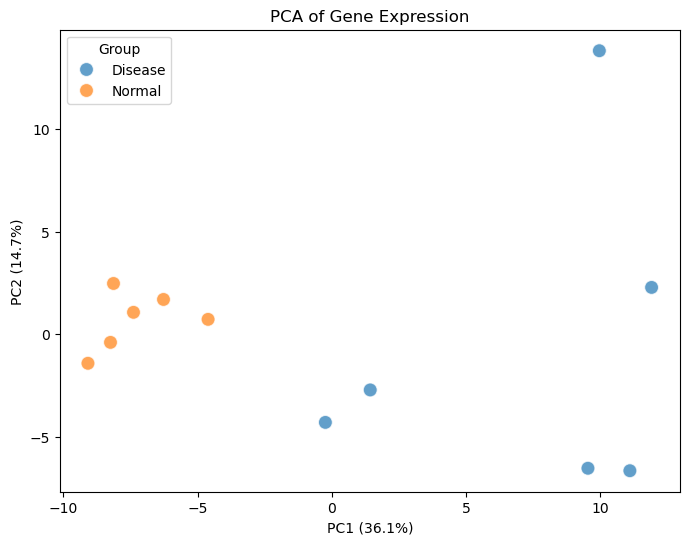

In [27]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='PC1', y='PC2', hue='Group', data=pca_df, s=100, alpha=0.7)  # added alpha
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.title("PCA of Gene Expression")
plt.legend(title='Group')
plt.show()

### Output and Visualization

## Net Graph

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

# load transition matrix
if chosen_method == "pearson":
    transition_df = pearson_corr
    transition_fdr = pearson_fdr
else:
    transition_df = spearman_corr
    transition_fdr = spearman_fdr

print(transition_df.head())

# Count cells where FDR < 0.05
count_significant = (transition_fdr < 0.05).sum().sum() - transition_fdr.shape[0]
print(f"Number of significant cells (FDR < 0.05): {count_significant}")

symbol      CETN2   SEPTIN6    KLHL13     KIF4A    ATXN10   SEPTIN5     CECR2  \
symbol                                                                          
CETN2    1.000000  0.942857  0.657143  0.714286  1.000000  0.028571 -0.257143   
SEPTIN6  0.942857  1.000000  0.600000  0.771429  0.942857  0.257143 -0.200000   
KLHL13   0.657143  0.600000  1.000000  0.028571  0.657143 -0.485714  0.085714   
KIF4A    0.714286  0.771429  0.028571  1.000000  0.714286  0.657143 -0.600000   
ATXN10   1.000000  0.942857  0.657143  0.714286  1.000000  0.028571 -0.257143   

symbol        SON   SEPTIN3     AURKA  ...   POLDIP2      GIT1  RAB11FIP4  \
symbol                                 ...                                  
CETN2    0.828571  0.542857  0.771429  ...  0.371429 -0.085714   0.371429   
SEPTIN6  0.885714  0.657143  0.828571  ...  0.542857  0.085714   0.485714   
KLHL13   0.714286  0.485714  0.428571  ... -0.200000 -0.542857   0.771429   
KIF4A    0.428571  0.600000  0.600000  ...  0.7

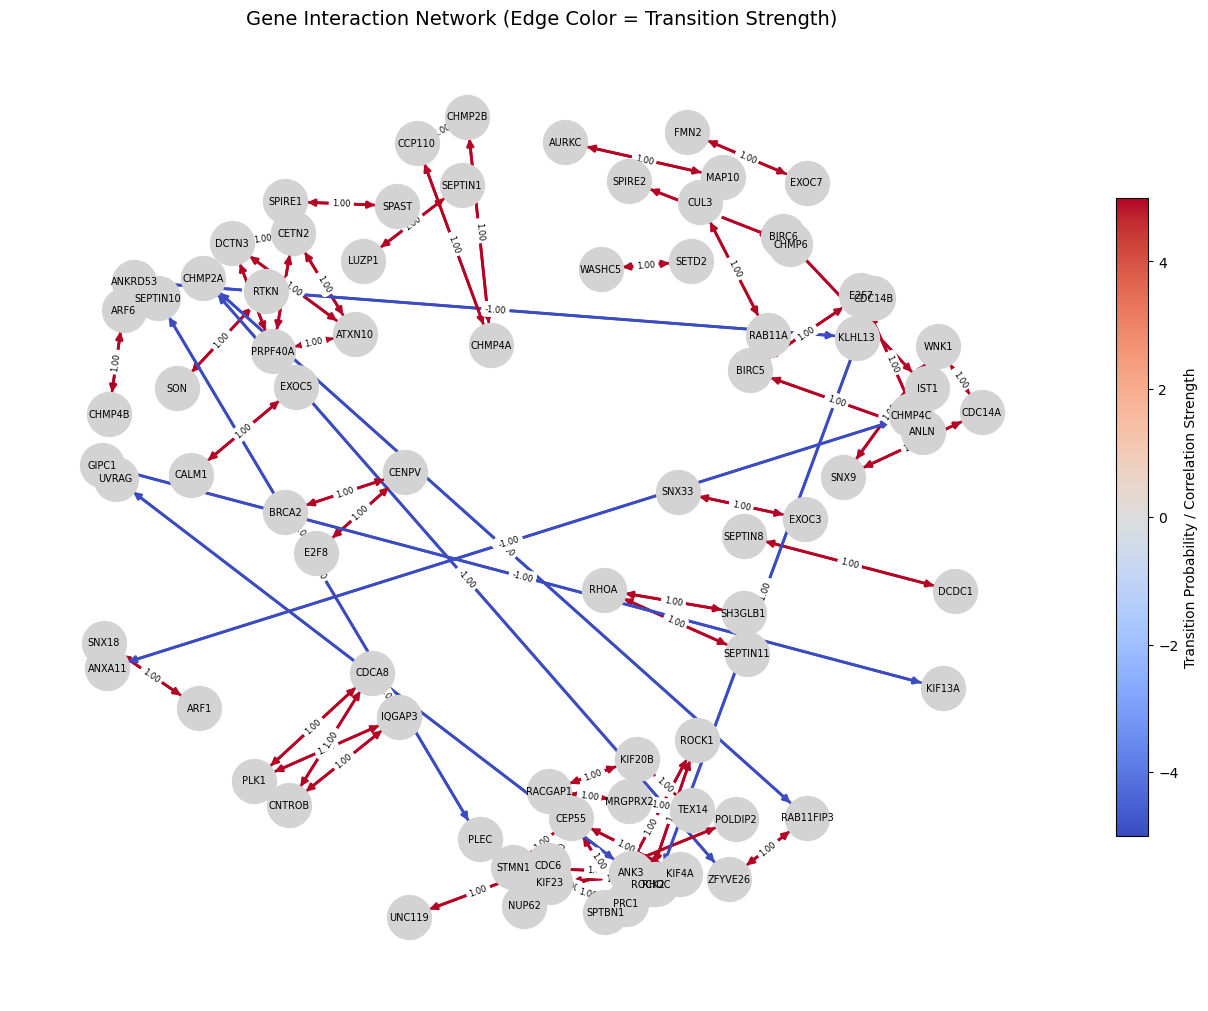

In [29]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

G = nx.DiGraph()

# Add edges with weights (probabilities)
n = 0
maxN = 10000
for from_gene in transition_df.index:
    for to_gene in transition_df.columns:
        fdr = transition_fdr.loc[from_gene, to_gene]
        weight = transition_df.loc[from_gene, to_gene]
        if abs(weight) > 0 and from_gene != to_gene and fdr < 0.01:
            G.add_edge(from_gene, to_gene, weight=weight)
            n += 1
            if n >= maxN:
                break
        if n >= maxN:
            break

# adjusted spacing for nodes
pos = nx.spring_layout(G, seed=42, k=0.5)  # Adjust 'k' for more spacing, larger k = more spacing
# or circular_layout for even spacing
# pos = nx.circular_layout(G)

# Get edge weights
weights = [G[u][v]['weight'] * 5 for u, v in G.edges()]  # scale up for visibility

# Set up colormap for edge colors
cmap = plt.cm.coolwarm

# Normalize weights between 0 and 1 for colormap scaling
norm = plt.Normalize(vmin=min(weights), vmax=max(weights))
edge_colors = [cmap(norm(w)) for w in weights]

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 10), constrained_layout=True)

# Draw the network
nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=1000,
    node_color="lightgrey",
    edge_color=edge_colors,
    width=2,
    font_size=7,  # Adjust font size for labels
    arrows=True,
    ax=ax
)

# Colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, fraction=0.03, pad=0.04)
cbar.set_label("Transition Probability / Correlation Strength")

# Edge labels with smaller font size
edge_labels = {(u, v): f"{G[u][v]['weight']:.2f}" for u, v in G.edges()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color="black", font_size=6, ax=ax)

# Title
plt.title("Gene Interaction Network (Edge Color = Transition Strength)", fontsize=14)

# Show the plot
plt.show()

## Heat Map

In [30]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns 

def add_stars(fdr):
    """Add significance stars, excluding diagonal"""
    annotations = []
    for i in range(len(fdr)):
        row = []
        for j in range(len(fdr.columns)):
            if i == j:
                text = ''  # No annotation for diagonal
            else:
                p_val = fdr.iloc[i, j]
                if p_val < 0.01:
                    text = '**'
                elif p_val < 0.05:
                    text = '*'
                else:
                    text = ''
            row.append(text)
        annotations.append(row)
    return annotations

In [31]:
def find_genes_with_stars(fdr):
    """Find genes that have significant correlations"""
    genes_with_stars = set()
    
    for i in range(len(fdr)):
        gene = fdr.index[i]
        for j in range(len(fdr.columns)):
            if i != j:  # Exclude diagonal
                p_val = fdr.iloc[i, j]
                if p_val < 0.05:  # Has * or **
                    genes_with_stars.add(gene)
                    break
    return genes_with_stars

In [32]:
# Load datasets
r2_cancer = pd.read_csv("lin/spearman_gene_correlation_r2_DS.csv", index_col=0)
r2_norm = pd.read_csv("lin/spearman_gene_correlation_r2_NM.csv", index_col=0)
fdr_cancer = pd.read_csv("lin/spearman_gene_correlation_fdr_DS.csv", index_col=0)
fdr_norm = pd.read_csv("lin/spearman_gene_correlation_fdr_NM.csv", index_col=0)

In [33]:
# Find genes with significant correlations
cancer_genes_with_stars = find_genes_with_stars(fdr_cancer)
normal_genes_with_stars = find_genes_with_stars(fdr_norm)

print(f"Cancer genes with significant correlations: {len(cancer_genes_with_stars)}")
print(f"Normal genes with significant correlations: {len(normal_genes_with_stars)}")


Cancer genes with significant correlations: 97
Normal genes with significant correlations: 89


In [34]:
# Create annotations
ann_c = add_stars(fdr_cancer)
ann_n = add_stars(fdr_norm)

/Users/pfb/.conda/envs/project/lib/python3.14/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/pfb/.conda/envs/project/lib/python3.14/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


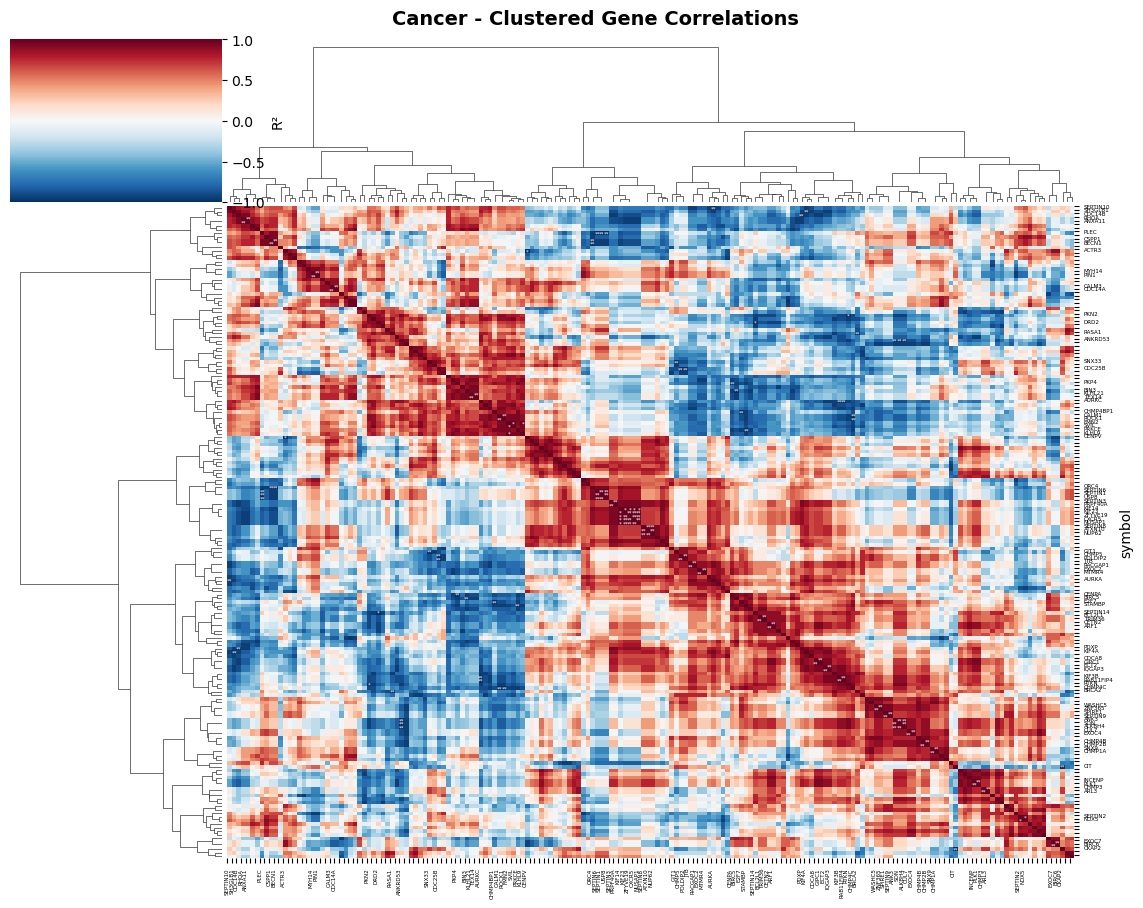

In [35]:
# Cancer clustered heatmap
cancer_cluster = sns.clustermap(r2_cancer, 
                               vmin=-1, vmax=1,
                               annot=ann_c, 
                               fmt='', 
                               cmap='RdBu_r',
                               figsize=(12, 10),
                               method='ward',
                               metric='euclidean',
                               cbar_pos=(0.01, 0.3, 0.01, 0.05),  # [left, bottom, width, height]
                               cbar_kws={'label': 'R²'},
                               annot_kws={'size': 4},
                               xticklabels=True,
                               yticklabels=True)

# Adjust title positioning - move it higher and add padding
cancer_cluster.fig.suptitle('Cancer - Clustered Gene Correlations', 
                           y=0.95, fontsize=14, fontweight='bold')

# Add extra space at the top for the title
cancer_cluster.fig.subplots_adjust(top=0.92)

# Get the reordered gene names after clustering
cancer_reordered_genes = cancer_cluster.data2d.index.tolist()
cancer_reordered_cols = cancer_cluster.data2d.columns.tolist()

# Set ticks for all genes first, then modify labels
cancer_cluster.ax_heatmap.set_yticks(range(len(cancer_reordered_genes)))
cancer_cluster.ax_heatmap.set_xticks(range(len(cancer_reordered_cols)))

# Create labels showing only significant genes
cancer_ylabels = [gene if gene in cancer_genes_with_stars else '' for gene in cancer_reordered_genes]
cancer_xlabels = [gene if gene in cancer_genes_with_stars else '' for gene in cancer_reordered_cols]

cancer_cluster.ax_heatmap.set_yticklabels(cancer_ylabels, fontsize=4)
cancer_cluster.ax_heatmap.set_xticklabels(cancer_xlabels, rotation=90, fontsize=4)

plt.show()

/Users/pfb/.conda/envs/project/lib/python3.14/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/pfb/.conda/envs/project/lib/python3.14/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


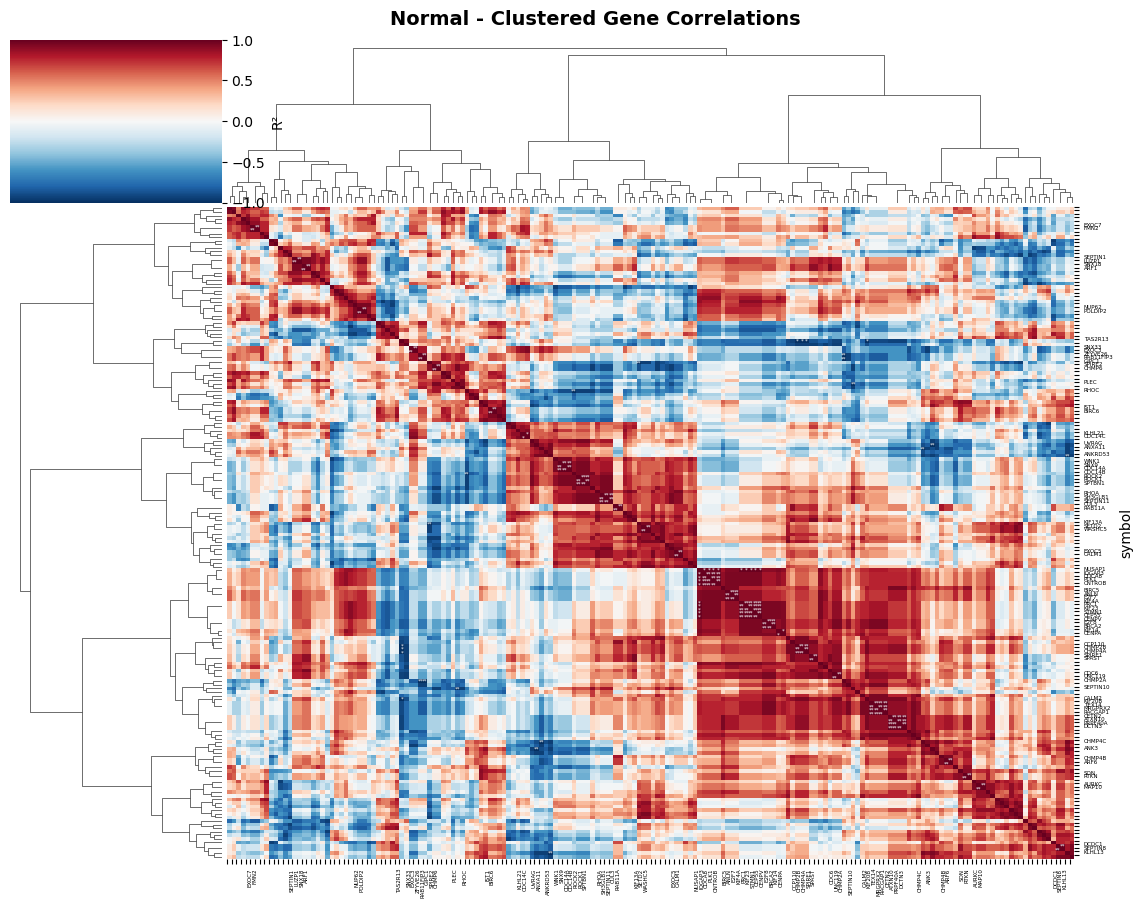


Genes displayed in cancer heatmap: ['SEPTIN10', 'SH3GLB1', 'CDC14B', 'RHOA', 'ANXA11', 'PLEC', 'CSPP1', 'BECN1', 'ACTR3', 'MYH14', 'PIN1', 'CALM3', 'CDC14A', 'PKN2', 'DRD2', 'RASA1', 'ANKRD53', 'SNX33', 'CDC25B', 'PKP4', 'BIN3', 'KLHL21', 'TEX14', 'AURKC', 'CHMP4BP1', 'CALM1', 'ROCK1', 'FMN2', 'SVIL', 'PRKCE', 'KLHL9', 'CENPV', 'ORC4', 'SEPTIN6', 'SEPTIN1', 'USP8', 'SEPTIN3', 'PRPF40A', 'KIF14', 'KIF23', 'ZFYVE19', 'CXCR5', 'NUSAP1', 'SEPTIN8', 'ATXN10', 'NUP62', 'GIT1', 'CHMP5', 'POLDIP2', 'JTB', 'RACGAP1', 'EXOC2', 'MTMR4', 'AURKA', 'CENPA', 'BIRC5', 'E2F7', 'STAMBP', 'SEPTIN14', 'BCL2L1', 'TRIM36', 'CETN2', 'ARF1', 'PDXP', 'KIF4A', 'CDCA8', 'GIPC1', 'ECT2', 'IQGAP3', 'KIF3B', 'RAB11FIP4', 'RTKN', 'CHMP4C', 'BRCA2', 'WASHC5', 'ZNF365', 'SPIRE1', 'SEPTIN9', 'ANK3', 'SON', 'ALKBH4', 'CUL7', 'EXOC4', 'CHMP4B', 'CHMP2B', 'SNX9', 'CHMP1A', 'CIT', 'INCENP', 'PLK1', 'CHMP3', 'ARL3', 'SEPTIN2', 'NOX5', 'EXOC7', 'BIRC6', 'CKAP2']
Genes displayed in normal heatmap: ['EXOC7', 'FMN2', 'SEPTIN1'

In [36]:
# Normal clustered heatmap  
normal_cluster = sns.clustermap(r2_norm, 
                               vmin=-1, vmax=1,
                               annot=ann_n, 
                               fmt='', 
                               cmap='RdBu_r',
                               figsize=(12, 10),
                               method='ward',
                               metric='euclidean',
                               cbar_pos=(0.01, 0.3, 0.01, 0.05),  # [left, bottom, width, height]
                               cbar_kws={'label': 'R²'},
                               annot_kws={'size': 4},
                               xticklabels=True,
                               yticklabels=True)

# Adjust title positioning - move it higher and add padding
normal_cluster.fig.suptitle('Normal - Clustered Gene Correlations', 
                           y=0.95, fontsize=14, fontweight='bold')

# Add extra space at the top for the title
normal_cluster.fig.subplots_adjust(top=0.92)

# Get the reordered gene names after clustering
normal_reordered_genes = normal_cluster.data2d.index.tolist()
normal_reordered_cols = normal_cluster.data2d.columns.tolist()

# Set ticks for all genes first, then modify labels
normal_cluster.ax_heatmap.set_yticks(range(len(normal_reordered_genes)))
normal_cluster.ax_heatmap.set_xticks(range(len(normal_reordered_cols)))

# Create labels showing only significant genes
normal_ylabels = [gene if gene in normal_genes_with_stars else '' for gene in normal_reordered_genes]
normal_xlabels = [gene if gene in normal_genes_with_stars else '' for gene in normal_reordered_cols]

normal_cluster.ax_heatmap.set_yticklabels(normal_ylabels, fontsize=4)
normal_cluster.ax_heatmap.set_xticklabels(normal_xlabels, rotation=90, fontsize=4)

plt.show()

# Optional: Print which genes are being shown
print(f"\nGenes displayed in cancer heatmap: {[g for g in cancer_reordered_genes if g in cancer_genes_with_stars]}")
print(f"Genes displayed in normal heatmap: {[g for g in normal_reordered_genes if g in normal_genes_with_stars]}")

## Scatter Plot

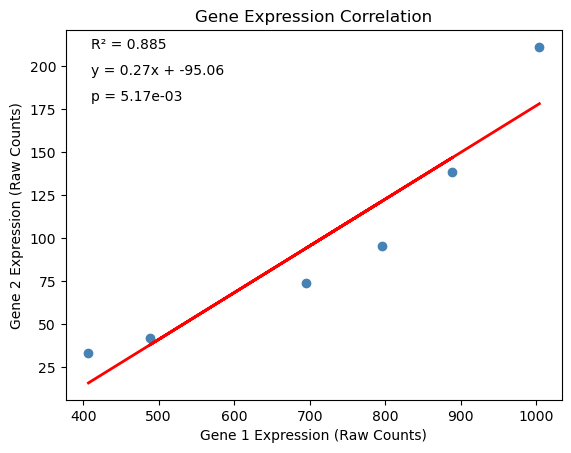

R² = 0.8849
P-value = 5.17e-03


In [3]:
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import sys
from dictionary_of_lists_for_scatterplot_GENE_NAMES_final import make_dictionary_from_raw_data_for_visualisation

#Raw data will be prepared in a dictionary format. 
raw_orig = make_dictionary_from_raw_data_for_visualisation('GSE280284_Processed_data_files.txt')
ctrl_dict = raw_orig[0] #this is the parsed dictionary from the raw reads
exp_dict = raw_orig[1]


geo1 = exp_dict['KIF23'] #geneID of interest
geo2 = exp_dict['CXCR5'] #geneID of interest
# print(geo1)
# print(geo2)
data = {'X': geo1, 'Y': geo2}

df = DataFrame(data, columns = ['X', 'Y'])
m, b, r_value, p_value, std_err = scipy.stats.linregress(df['X'], df['Y'])

fig, ax = plt.subplots() #this creates a blank figure and axis for plotting 
                         #(fig= entire plot window) (ax = the actual plot area,labels,styling)
#plot the data points
ax.scatter(df['X'], df['Y'], color = 'steelblue', label = 'title of the scatterplot')

#plot the regression line
ax.plot(df['X'], m*df['X'] + b, color = 'red', linewidth = 2, label = 'regression')

#add statistics 
ax.annotate(f'R² = {r_value**2:.3f}', xy=(0.05, 0.95), xycoords='axes fraction')
ax.annotate(f'y = {m:.2f}x + {b:.2f}', xy=(0.05, 0.88), xycoords='axes fraction')
ax.annotate(f'p = {p_value:.2e}', xy=(0.05, 0.81), xycoords='axes fraction')

#labels and styling
ax.set_xlabel('Gene 1 Expression (Raw Counts)')
ax.set_ylabel('Gene 2 Expression (Raw Counts)')
ax.set_title('Gene Expression Correlation')

plt.show()

print(f"R² = {r_value**2:.4f}")
print(f"P-value = {p_value:.2e}")